# MALIS Lab Session 3 - Fall 2021
## Deadline ...

**Group :** pronestiblias

**Federico TIBLIAS, Massimiliano PRONESTI**

The aim of this lab is to practice with Support Vector Machines (SVM), and in particular with the PEGASOS (Primal Estimated sub-GrAdient SOlver for SVM) algorithm. PEGASOS is a fast stochastic sub-gradient descent algorithm for solving the primal optimization problem cast by an SVM. In the first part of this lab, you will be to implement PEGASOS. As it is based on a primal problem, it is only adapted to linear kernels; the authors of PEGASOS proposed a way to use other non-linear kernels, at the price of time efficiency. Therefore in the second part of the lab, instead of implementing that less efficient version of PEGASOS, you will work on a features mapping method that will allow you to separate non-linearly separable datasets using PEGASOS. You will test your implementations on four datasets.

Experiments should be made by groups of two students. Each group should produce a Jupyter Notebook with all their results and comments. We strongly encourage the addition of plots and visual representations to the report, bearing in mind that comments on graphical data are still necessary. Code for adding images to your notebook: ```<img src="path/to/image.png" />```.

You can submit all the files as a compressed single file (e.g. zip).
Alternatively, **you can generate an html after running the full notebook and upload it**


<h2>Introduction</h2>
There are three parts to this lab session. 

1. A part on PEGASOS where you are asked to implement the stochastic version of PEGASOS

2. A part on features mapping

3. A part on soft SVM

Data are 2D. You can visualize them by running the following cell (red dots are labeled -1 and green dots are labeled 1).

In [14]:
print_solutions=False

data/dataset1.txt


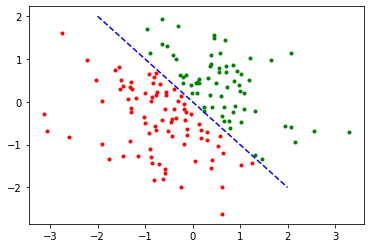

data/dataset2.txt


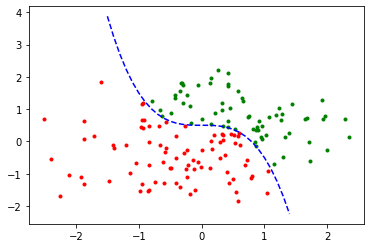

data/dataset3.txt


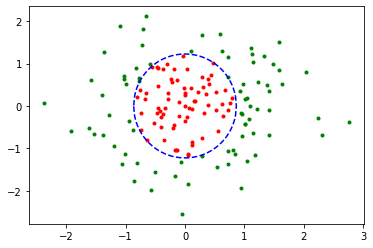

data/dataset4.txt


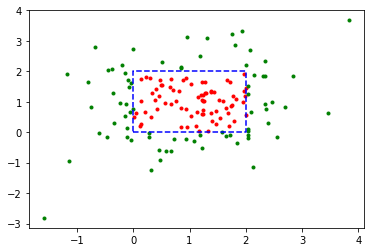

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import sqrt, cos, pi
import pandas as pd

# print the datasets and their delimiters
datasets = ["data/dataset" + str(x) + ".txt" for x in range(1, 5)]
for dataset in datasets :
    print(dataset)
    points_df=pd.read_csv(dataset,delimiter=' ')
    plt.plot(points_df.x_1[points_df.y==-1],points_df.x_2[points_df.y==-1],'r.') # points whose target y is -1
    plt.plot(points_df.x_1[points_df.y==1],points_df.x_2[points_df.y==1],'g.') # points whose target y is +1
    # draw exact delimiter
    if dataset == datasets[0]:
        plt.plot(np.array([0,40])/10-2,-np.array([0,40])/10+2, 'b--')
    elif dataset == datasets[1]:
        plt.plot([x/10-1.5 for x in range(30)], [0.5-((x/10)-1.5)**3 for x in range(30)], 'b--')
    elif dataset == datasets[2]:
        plt.plot([x/(4*17.321)-0.866 for x in range(120)]+[np.sqrt(3)/2], [np.sqrt(1.5-2*(x/(4*17.321)-0.866)**2) for x in range(120)]+[0], 'b--')
        plt.plot([x/(4*17.321)-0.866 for x in range(120)]+[np.sqrt(3)/2], [-np.sqrt(1.5-2*(x/(4*17.321)-0.866)**2) for x in range(120)]+[0], 'b--')
    elif dataset == datasets[3]:
        plt.plot([x/8 for x in range(17)] + [2 for x in range(17)] + [(2-x/8) for x in range(17)] + [0 for x in range(17)],
             [0 for y in range(17)] + [y/8 for y in range(17)] + [2 for y in range(17)] + [(2-y/8) for y in range(17)], 'b--')
    plt.show()
    

<h4>Question 1</h4>
According to the above plots, do these datasets seem to be linearly separable? On which of these datasets do you expect a linear SVM to perform well? On which ones do you think it will perform badly?

<h4>Your answer</h4>
Linear separability, in the scope of binary classification problems, means there exists at least one hyperplane for which all points belonging to a class fall on one side, and all points belonging to the other class fall on the other side.
Among the datasets proposed only the first one is linearly separable. The others are separable if we use some feature transformation or some kernel function.



<h2>Part 1: PEGASOS</h2>

<h3>How PEGASOS works</h3>

<i>That sub-part gives some intuition about how PEGASOS can actually find the solution of a problem cast by a linear SVM. Reading it is not required to do the lab, but we encourage you to have a look at it as it may help you for your implementation.</i>

Let us assume that given a set $S = \lbrace (x_i, y_i) \rbrace$ where $x_i \in \mathbb{R}^n$ and $y_i \in \lbrace -1, 1 \rbrace$, we want to find a solution of the following problem

$$\min_{w, b} \frac{1}{2} \Vert w \Vert^2 + C \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $C$ is a non-zero hyperparameter controlling the "softness" of the margin (the lower the $C$ the softer the margin), or equivalently

$$\min_{w, b} \frac{\lambda}{2} \Vert w \Vert^2 + \sum_i \max(0, 1-y_i(w^Tx_i + b))$$

where $\lambda$ replaces $C$ (the higher the $\lambda$ the softer the margin). We can get rid of the bias term $b$ by adding a constant feature to all the $x_i$ (we can assume without loss of generality that the value of the constant is 1) and by replacing $w$ by the concatenation of $w$ and $b$. In that setup, the optimization problem becomes (with $\tilde{w} = [w; b]$ and $\tilde{x_i} = [x_i; 1]$)

$$\min_{\tilde{w}} \frac{\lambda}{2} \Vert \tilde{w} \Vert^2 + \sum_i \max(0, 1-y_i(\tilde{w}^T\tilde{x_i})).$$

You can notice that the optimization problem we obtained is slightly different from the one we stated before, as $\Vert \tilde{w} \Vert^2$ should be replaced by $\Vert \tilde{w} \Vert^2 - b^2$. However, in practice, that difference has very few importance. Therefore in the following we will assume that $x_i \in \mathbb{R}^{n+1}$, $w \in \mathbb{R}^{n+1}$, and that the last feature of $x_i$ is always equal to 1. As we will work on the stochastic variant of PEGASOS, we will consider the following objective:

$$\min_{w_t} \frac{\lambda}{2} \Vert w_t \Vert^2 + \max(0, 1-y_{i_t}(w_t^Tx_{i_t}))$$

where $(x_{i_t}, y_{i_t})$ is a sample drawn randomly at iteration $t$ from $S$. The sub-gradient of the above objective is then given by:

$$\nabla w_t = \lambda w_t - \phi_I(x_{i_t}, y_{i_t}) y_{i_t}x_{i_t}$$

where $\phi_I$ is the indicator function of the set $I = \lbrace (x, y) \in R^d \times \lbrace -1, 1 \rbrace : y w^Tx < 1 \rbrace$ ($\phi_I(x, y) = 1$ if $(x, y) \in I$ and $\phi_I(x, y) = 0$ otherwise). Then, we compute $w_{t+1}$ using the following update formula:

$$w_{t+1} = w_t - \eta_t \nabla w_t$$

where $\eta_t = 1/(\lambda t)$. The algorithm stops after a predefined number of iterations. As you can understand, PEGASOS uses a stochastic gradient descent with learning rate $\eta_t$ to find the optimal parameters of an SVM. The next sub-part gives you a pseudo-code of PEGASOS. Your role will be to implement it based on that pseudo-code.

<h3>Pseudo-code of PEGASOS</h3>

Your task will now be to implement PEGASOS. An SVM class has been defined in utils.py. You are strongly encouraged to read it carefully to understand it.

<h4>Question 2</h4>
Complete the following implementation of PEGASOS.

<h4>Your answer</h4>

In [16]:
from utils import SVM, Dataset

def train(self, n_iterations, lambda_w, print_every_k=None,verbose=False):
    """
    Train function for an SVM model using PEGASOS.
    If verbose is TRUE print the accuracy every 'print_every_k' iterations

    INPUTS:
    - self containing in particular:
        self.train_dataset with inside
            self.train_dataset.input -> inputs in a numpy NxD array, N number of sample, D dimensions
            self.train_dataset.output -> outputs in a numpy X array
        self.w -> weights of the model initialized at random before. Length D+1, because 1 is the bias
    - n_iterations -> total number of epochs
    - lambda_w -> lambda in PEGASOS
    - print_every_k -> compute the accuracy of the model every 'print_every_k' epochs
    - verbose -> if TRUE, in addition of computing the accuracy, the model also print it every 'print_every_k' epochs
    """

    
    if not print_every_k:
        print_every_k = max(1, int(n_iterations/50))
        self.print_step=print_every_k
        # For n_iterations epochs
        for i in range(n_iterations): # equivalent for t in {1,...,T}
        
        # ! REMEMBER TO UPDATE self.w AT THE END OF EVERY ITERATION
        # ! self.train_dataset.input DOES NOT CONTAIN THE BIAS : a '1' in the dimension D+1
            # REMBER TO ADD THE '1' OF THE BIAS TO YOUR x VECTOR OR YOU WILL HAVE A SIZE MISMATCH
            # ADD THE BIAS IN THE LAST POSITION OF YOUR x VECTOR, OTHERWISE THE REST OF THE TRAIN WILL BE WRONG
            # x VECTOR OF [self.train_dataset.input[sample,:], 1]
        
        ################ YOUR CODE HERE #################
            N_samples = self.train_dataset.input.shape[0]
            rand_index = np.random.randint(0,N_samples)
            x_i = np.hstack([self.train_dataset.input[rand_index,:], 1])
            y_i = self.train_dataset.output[rand_index]
            eta_i = 1/(lambda_w * (i+1))
            indicator = (y_i * (self.w @ x_i)) < 1
            self.w = self.w - eta_i * lambda_w * self.w + y_i * x_i * indicator
        
        ################ END OF YOUR CODE ###############
        
            if not i%print_every_k:
                if verbose:
                    print("Epoch: ", i+1, " out of ", n_iterations)
                    self.print_accuracy()
                else:
                    self.compute_accuracy()
                    
SVM.train = train                    

In [17]:
# do NOT modify this cell
if print_solutions==True :
    %load ./solutions/part1_SVM_training.py

<h4>Question 3</h4>
Test your implementation on the four datasets (train your SVM during 1500 iterations with $\lambda = 0.0001$).
You have to:

1. create 2 objects Dataset, with the train dataset and test dataset for each dataset in the folder data
2. initialize your SVM model with the 2 objects
3. use the train function of your SVM object to train it
4. use the make_plot function of your SVM object to make the plot of its accuracy
5. use the function print_accuracy of your SVM object to see the final training accuracy

Do you find the results that you forecast in Question 1?

<h4>Your answer</h4>
We indeed find a high accuracy for the first dataset, a slightly lower one for the second (the curved line can be approximated with a straight boundary) and a drastcally lower one for the third and last datasets.
In the last two there isn't any line able to divide the classes in a useful way, thus the accuracy results are akin to chosing at random

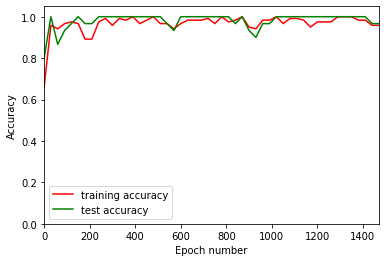

Accuracy: 99.16666666666667 %


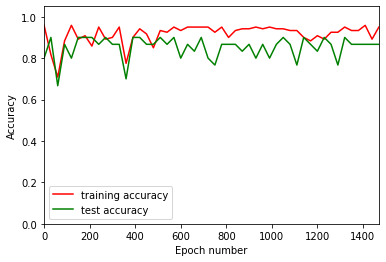

Accuracy: 90.83333333333333 %


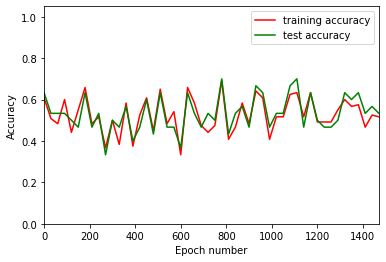

Accuracy: 50.0 %


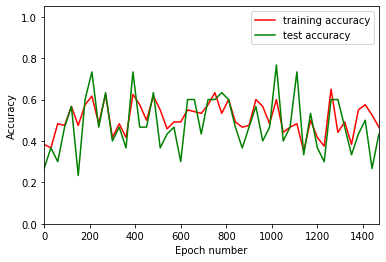

Accuracy: 55.833333333333336 %


In [18]:
n_iterations = 1500
lambda_w = 0.0001

datasets_train = [ Dataset("data/dataset" + str(x) + "_train.txt") for x in range(1, 5)]
datasets_test =  [ Dataset("data/dataset" + str(x) + "_test.txt") for x in range(1, 5)]

svms = [SVM(d_tr,d_ts) for d_tr, d_ts in zip(datasets_train,datasets_test)]

for svm in svms:
    svm.train(n_iterations=n_iterations,lambda_w=lambda_w)
    svm.make_plot()
    svm.print_accuracy()


In [19]:
# do NOT modify this cell
if print_solutions==True :
    %load ./solutions/part1_question3.py

<h2>Part 2: Features Maps</h2>

As you know, it is possible to use the "Kernel Trick" to separate non-linearly separable datasets with SVMs. This trick is meant to be applied on the dual problem. As PEGASOS is based on the primal problem, the Kernel Trick cannot be used easily with PEGASOS. However, there is a method to approximate the feature space corresponding to a given kernel. In this part, you will implement and test that method. You will not be asked to dig into the mathematical theory behind that method, but if you wish, you can find more informations in the paper <i>Random Features for Large-Scale Kernel Machines</i> by Ali Rahimi and Ben Recht [1].

<h2>Approximating the Radial Basis Function (RBF) kernel</h2>

The Radial Basis Function $K_\gamma$ is one of the most common kernels used with SVMs. It is defined as follows ($x, y \in \mathbb{R}^d$):

$$ K_\gamma(x, y) = \exp(-\gamma \Vert x - y \Vert^2).$$

Its feature space is of infinite dimension. However, you can approximate it according to the following algorithm (details in [1]):

The pseudo-code above transforms data from its original space to a new feature space approximating the feature space corresponding to the RBF kernel. You will now implement that pseudo-code.

<h4>Question 4</h4>
Complete the following implementation of the FeaturesMap class.

<h4>Your answer</h4>

In [78]:
import numpy as np
from utils import Dataset
from math import pi
import random

class FeaturesMap:

    def __init__(self, D, d, gamma):
        """
        INPUT:
        - d : old dimensions
        - D : new dimensions
        - gamma : softness/hardness parameter
        """
        mean = np.zeros(d)
        cov = 2 * d * gamma * np.eye(d)
        self.D = D
        self.w = np.array([np.random.multivariate_normal(mean, cov) for _ in range(D)])
        self.b = np.array([random.random() * 2 * pi for _ in range(D)])

    def __call__(self, dataset):
        outputs = dataset.output
        S_prime = [] # S'
        S = dataset.input

        """
        # compact version
        S_prime = [
            [
               np.sqrt(2 / D) * np.cos(np.dot(self.w[i], x) + self.b[i])
                for i in range(D)
            ]
            for x in S
        ]
        """

        # extended version (as in the pseudocode)
        for x in S:
            # compute z and append the values to S_prime keeping it as a list if you want
            
            ########## YOUR CODE HERE #################
            # computing Z according to the definition
            z = np.asarray([
                np.cos(np.dot(self.w[i], x) + self.b[i])
                for i in range(self.D)
            ])
            z *= np.sqrt(2 / self.D)
            S_prime.append(z)

            ########## END OF YOUR CODE HERE ##########
        new_data = Dataset(input_size=self.D, length=dataset.len)
        new_data.input = np.array(S_prime)
        new_data.output = outputs
        
        return new_data

In [79]:
# do NOT modify this cell
if print_solutions==True :
    %load ./solutions/part2_features_map.py

<h4>Question 5</h4>
Test your implementation on the four artificial datasets. Train your SVM during 1500 iterations with $\lambda = 0.0001$. The dimension of the feature space is 200 and $\gamma = 1$.

1. Create Dataset() objects for each train and test dataset
2. Move each train and test Dataset() object using FeaturesMap()
3. Init and train SVM with featured map model

How do your results change with respect to what you found in Question 3?



Dataset 1


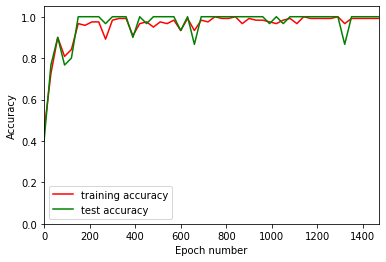

Accuracy: 99.16666666666667 %


Dataset 2


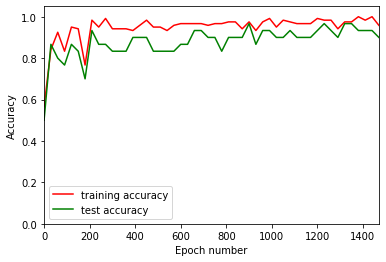

Accuracy: 99.16666666666667 %


Dataset 3


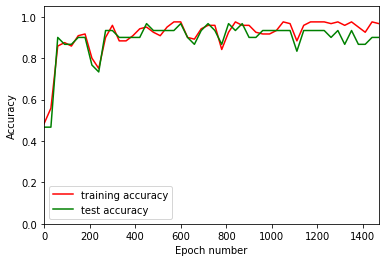

Accuracy: 98.33333333333333 %


Dataset 4


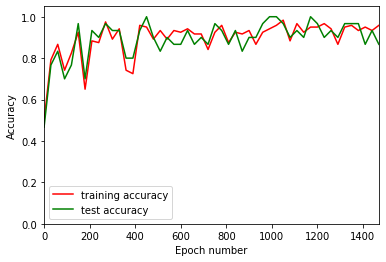

Accuracy: 96.66666666666667 %


In [80]:
# to avoid duplicating the code, we preferred
# turning the original code included in this notebook
# into a helper function so that we can simply
# specify the parameters
def test_svm(gamma: int = 1,
             lambda_w: float = 1e-4,
             n_iterations: int = 1500,
             D: int = 200) -> None:
    for i in range(1,5):
        print("\n\nDataset", i)
        datafile = f"data/dataset{i}_train.txt"
        train_data = Dataset(datafile)
        test_datafile = f"data/dataset{i}_test.txt"
        test_data = Dataset(test_datafile)

        d = train_data.input_size

        features_map = FeaturesMap(D, d, gamma)
        new_train_data = features_map(train_data)
        new_test_data = features_map(test_data)

        # fit and train your SVM model using new_train_data and  new_test_data
        # then use make_plot() of your SVM object
        # then use print_accuracy() of your SVM object

        ############# YOUR CODE #############
        svm_ = SVM(new_train_data,new_test_data)
        svm_.train(n_iterations, lambda_w)
        svm_.make_plot()
        svm_.print_accuracy()
        ########## END YOUR CODE ############

gamma = 1
test_svm(gamma)

With respect to the results obtained in Question 3, we can notice that the accuracy for the non-linearly separable datasets increase greatly.

In [48]:
# do NOT modify this cell
if print_solutions==True :
    %load ./solutions/part2_question5.py

<h2>The role of $\gamma$ in the RBF kernel</h2>

<h4>Question 6</h4>
Do the same tests with $\gamma = 10^{-6}$. What do you notice? How can you explain your results?



Dataset 1


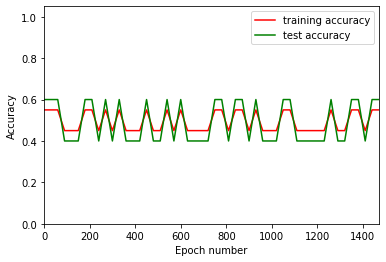

Accuracy: 55.00000000000001 %


Dataset 2


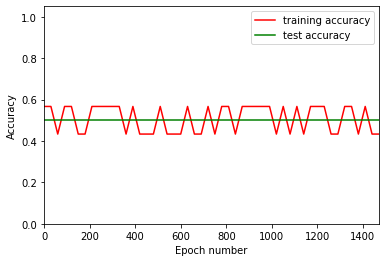

Accuracy: 56.666666666666664 %


Dataset 3


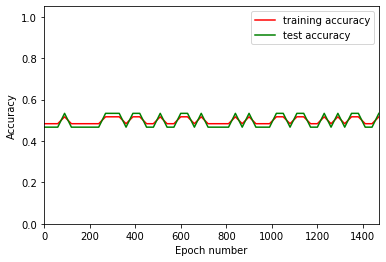

Accuracy: 48.333333333333336 %


Dataset 4


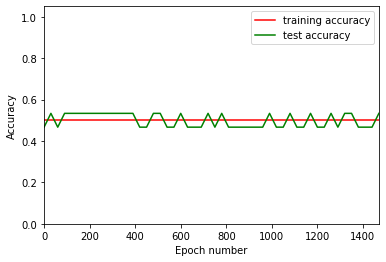

Accuracy: 50.0 %


In [81]:
gamma = 1e-6
test_svm(gamma)

### Comment
...

In [82]:
# do NOT modify this cell
if print_solutions==True :
    %load ./solutions/part2_question6.py

<h4>Question 7</h4>
Do the same tests with $\gamma = 10^{4}$. What do you notice? How can you explain your results?



Dataset 1


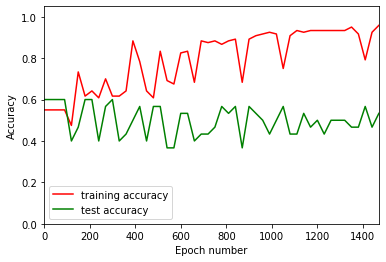

Accuracy: 95.83333333333334 %


Dataset 2


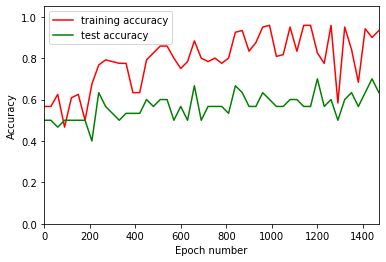

Accuracy: 88.33333333333333 %


Dataset 3


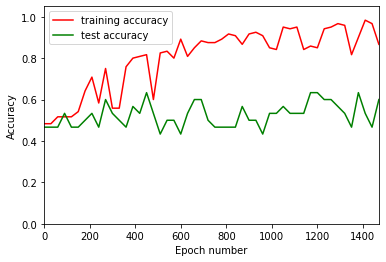

Accuracy: 86.66666666666667 %


Dataset 4


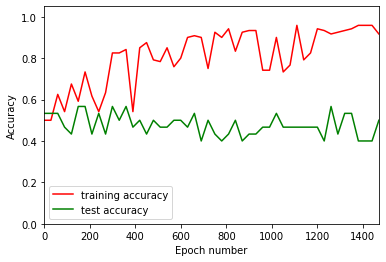

Accuracy: 91.66666666666666 %


In [84]:
gamma = 1e4
test_svm(gamma)

In [73]:
# do NOT modify this cell
if print_solutions==True :
    %load ./solutions/part2_question7.py

### Comment:
...